# DETECTION D'ANOMALIES SUR DES PIECES d'USURE
Un test d'usure a été pratiqué sur 4 pièces qui étaient montées ensemble, à la fin du test la pièce 1 a eu une failure
Les données sont enregistrées par des capteurs toutes les 10 minutes et représentent des vibrations sur les 4 pièces (données NASA)

In [37]:
# d'apres https://arun-thomas.xyz/2019-06-18-BearingAnalytics/

# library
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
# sns.set(color_codes=True)

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Load data
Gear degradation occur gradually over time, so we use one datapoint every 10 minutes in the following analysis.

In [38]:
merged_data = pd.read_csv('../data/merged_dataset_BearingTest_2.csv')

merged_data.columns = ['dt','Bearing 1','Bearing 2','Bearing 3','Bearing 4']
merged_data=merged_data.set_index('dt')

In [39]:
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
dt,,,,
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


In [40]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 984 entries, 2004-02-12 10:32:39 to 2004-02-19 06:22:39
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Bearing 1  984 non-null    float64
 1   Bearing 2  984 non-null    float64
 2   Bearing 3  984 non-null    float64
 3   Bearing 4  984 non-null    float64
dtypes: float64(4)
memory usage: 38.4+ KB


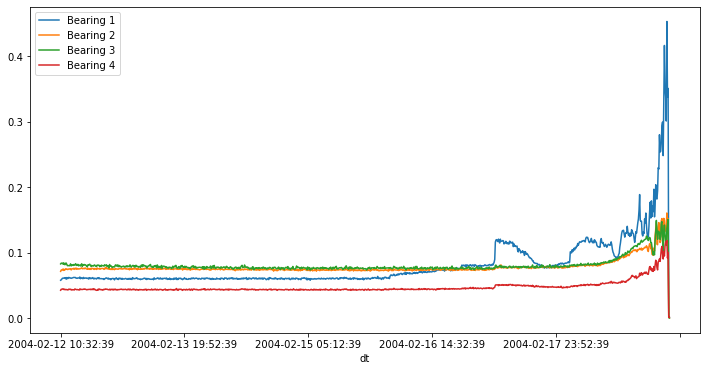

In [41]:
merged_data.plot(figsize = (12,6))


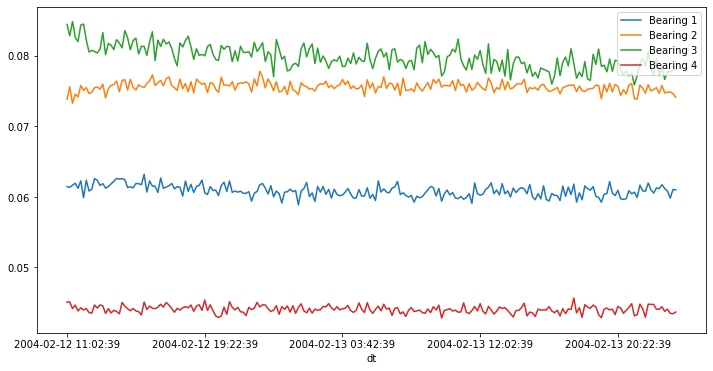

In [42]:
dataset_train['2004-02-12 10:32:39':'2004-02-15 23:42:39'].plot(figsize = (12,6))

### Prévision avec Prophet et détection d'anomalie sur le capteur 1

In [44]:
from fbprophet import Prophet

In [122]:
# On va apprendre un modele sur la série SAINE
healthy_bearing1 = merged_data['2004-02-12 10:32:39':'2004-02-15 23:42:39']['Bearing 1']

# Creating training dataframe
prophet_healthy_train = pd.DataFrame()
prophet_healthy_train['ds'] = healthy_bearing1.index
prophet_healthy_train['y'] = healthy_bearing1.values

prophet_healthy_train.head()

,ds,y
0,2004-02-12 10:32:39,0.058333
1,2004-02-12 10:42:39,0.058995
2,2004-02-12 10:52:39,0.060236
3,2004-02-12 11:02:39,0.061455
4,2004-02-12 11:12:39,0.061361


In [105]:
prophet_healthy_train.shape

(512, 2)

In [46]:
# On apprend un modele sans les options de saisonnalité car il n'y en a pas
# La bande de confiance est fixée au max 100% qui dit que toutes les données en conditions normales doivent etre dedans
# on peut la baisser un peu mais cela risque de créer bcp de faux positifs
m = Prophet(interval_width = 1)
# avec les données saines
m.fit(prophet_healthy_train)

INFO:numexpr.utils:NumExpr defaulting to 1 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [48]:
forecast = m.predict(prophet_healthy_train)
forecast['fact'] = prophet_healthy_train['y'].reset_index(drop = True)


In [90]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,fact
0,2004-02-15 23:22:39,0.061073,0.059383,0.063361,0.061073,0.061073,0.000046,0.000046,0.000046,0.000046,0.000046,0.000046,0.0,0.0,0.0,0.061119,0.061558
1,2004-02-15 23:32:39,0.061077,0.059105,0.063019,0.061077,0.061077,0.000050,0.000050,0.000050,0.000050,0.000050,0.000050,0.0,0.0,0.0,0.061127,0.061188
2,2004-02-15 23:42:39,0.061080,0.058937,0.063060,0.061080,0.061080,0.000054,0.000054,0.000054,0.000054,0.000054,0.000054,0.0,0.0,0.0,0.061134,0.061323
3,2004-02-15 23:52:39,0.061084,0.059044,0.062955,0.061083,0.061086,0.000056,0.000056,0.000056,0.000056,0.000056,0.000056,0.0,0.0,0.0,0.061140,0.064163
4,2004-02-16 00:02:39,0.061088,0.059127,0.063097,0.061084,0.061091,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.0,0.0,0.0,0.061146,0.060751


In [104]:
forecast.shape

(148, 16)

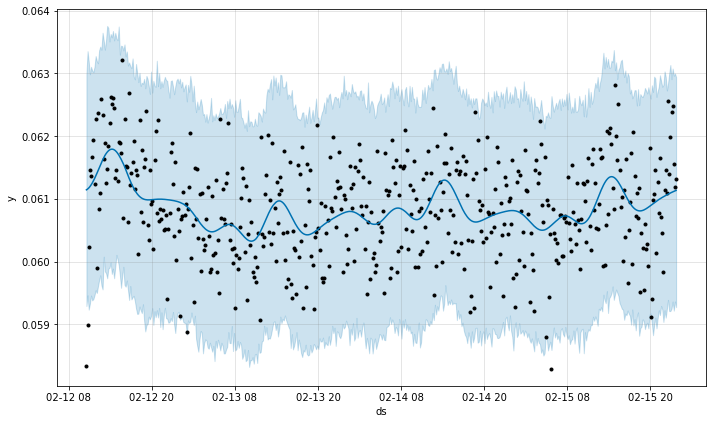

In [57]:
fig1 = m.plot(forecast)


In [58]:
#fig1 = healthy_bearing1.plot(figsize = (12,6), title="Observations d'apprentissage")
#fig1.set(xlabel="Mois (MM)-Date(DD) Heure", ylabel="Vibration/Acceleration(g)")

In [91]:
forecast=forecast.set_index('ds')

### PARTIE 2 APPLICATION DU MODELE SUR DONNEES NOUVELLES POUR DETECTER DES EVENTUELLES ANOMALIES

In [59]:
prophet_faultydata = merged_data['2004-02-15 23:22:39':'2004-02-16 23:52:39']['Bearing 1']
prophet_faultydata.head()

dt
2004-02-15 23:22:39    0.061558
2004-02-15 23:32:39    0.061188
2004-02-15 23:42:39    0.061323
2004-02-15 23:52:39    0.064163
2004-02-16 00:02:39    0.060751
Name: Bearing 1, dtype: float64

In [61]:
prophet_faulty_test = pd.DataFrame()
prophet_faulty_test['ds'] = prophet_faultydata.index
#pd.to_datetime(prophet_healthy.index, format='%Y.%m.%d.%H.%M.%S')
prophet_faulty_test['y'] = prophet_faultydata.values
prophet_faulty_test.head()

,ds,y
0,2004-02-15 23:22:39,0.061558
1,2004-02-15 23:32:39,0.061188
2,2004-02-15 23:42:39,0.061323
3,2004-02-15 23:52:39,0.064163
4,2004-02-16 00:02:39,0.060751


In [123]:
forecast_test = m.predict(prophet_faulty_test)
forecast_test['fact_test'] = prophet_faulty_test['y'].reset_index(drop = True)

In [124]:
forecast_test.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,fact_test
143,2004-02-16 23:12:39,0.061584,0.059588,0.063705,0.060367,0.062674,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,0.0,0.0,0.0,0.061625,0.079973
144,2004-02-16 23:22:39,0.061588,0.059414,0.063757,0.060361,0.062687,0.000046,0.000046,0.000046,0.000046,0.000046,0.000046,0.0,0.0,0.0,0.061634,0.080762
145,2004-02-16 23:32:39,0.061591,0.059546,0.063962,0.060354,0.062701,0.000050,0.000050,0.000050,0.000050,0.000050,0.000050,0.0,0.0,0.0,0.061641,0.081670
146,2004-02-16 23:42:39,0.061595,0.059609,0.063880,0.060347,0.062714,0.000054,0.000054,0.000054,0.000054,0.000054,0.000054,0.0,0.0,0.0,0.061649,0.078493
147,2004-02-16 23:52:39,0.061599,0.059511,0.063870,0.060341,0.062728,0.000056,0.000056,0.000056,0.000056,0.000056,0.000056,0.0,0.0,0.0,0.061655,0.081674


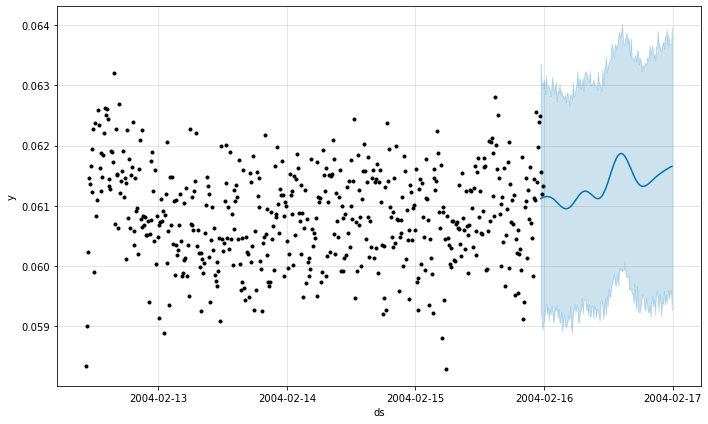

In [66]:
fig1 = m.plot(forecast)

In [129]:
forecast_test=forecast_test.set_index('ds')
prophet_healthy_train=prophet_healthy_train.set_index('ds')

In [131]:
# Apprentissage + Test

previsions=pd.concat([prophet_healthy_train,forecast_test])
previsions.head()

,y,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,fact_test
ds,,,,,,,,,,,,,,,,,
2004-02-12 10:32:39,0.058333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-02-12 10:42:39,0.058995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-02-12 10:52:39,0.060236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-02-12 11:02:39,0.061455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-02-12 11:12:39,0.061361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
previsions.head()
previsions['y'].mean()

0.06083979205832762

In [133]:
previsions=previsions.reset_index()

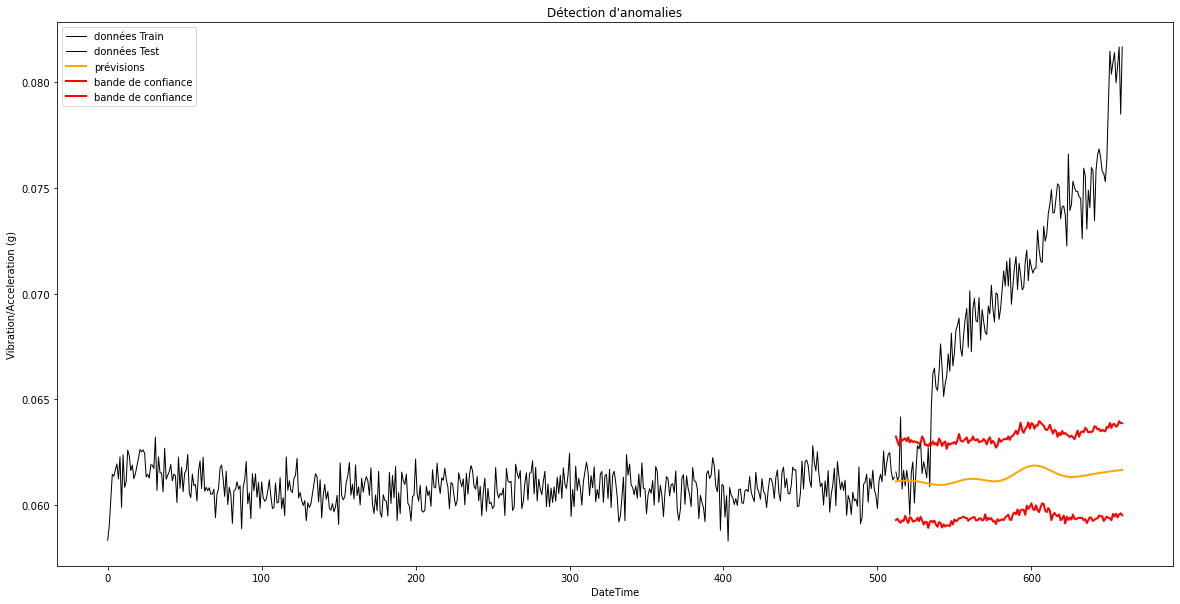

In [139]:
fig,ax=plt.subplots(figsize=(20, 10))
plt.plot(previsions['y'], color='black',lw=1, label = 'données Train')
plt.plot(previsions['fact_test'], color='black',lw=1, label = 'données Test')
plt.plot(previsions['yhat'], color='orange',lw=2, label = 'prévisions')
plt.plot(previsions['yhat_lower'], color='red',lw=2, label = 'bande de confiance')
plt.plot(previsions['yhat_upper'], color='red',lw=2, label = 'bande de confiance')
plt.xlabel('DateTime'); plt.ylabel('Vibration/Acceleration (g)'); plt.title("Détection d'anomalies")
plt.legend()
#plt.savefig('graph.jpg')

### Codons un détecteur d'anomalies qui déclenche une anomalie lorsqu'on sort de la bande de confiance
anomaly = 0/1 et importance qui vaut l'écart entre la réalité et la bande

In [73]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted



In [74]:
pred = detect_anomalies(forecast)

In [75]:
print(pred.anomaly.sum())
print(pred[pred.anomaly==1].head())

127
                    ds     trend      yhat  yhat_lower  yhat_upper      fact  \
3  2004-02-15 23:52:39  0.061084  0.061140    0.059044    0.062955  0.064163   
16 2004-02-16 02:02:39  0.061130  0.061089    0.059321    0.062994  0.062997   
23 2004-02-16 03:12:39  0.061155  0.060987    0.059235    0.062922  0.064636   
24 2004-02-16 03:22:39  0.061159  0.060975    0.058915    0.062835  0.066212   
25 2004-02-16 03:32:39  0.061163  0.060965    0.059053    0.062825  0.066479   

    anomaly  importance  
3         1    0.018827  
16        1    0.000038  
23        1    0.026512  
24        1    0.051009  
25        1    0.054962  


In [ ]:
# Si on constate plusieurs anomalies successives alors on alerte